**Install Dependencies**


In [ ]:
!pip install datasets transformers torchvision torch scikit-learn matplotlib


In [ ]:
!pip install --upgrade datasets


**Importing Dataset Unsing Streaming mode**

In [ ]:
from datasets import load_dataset

# Load dataset in streaming mode
dataset = load_dataset("HuggingFaceM4/WebSight", split="train", streaming=True)

# Fetch one example
sample = next(iter(dataset))

# Print dataset keys to verify
print("Keys:", sample.keys())  # Should print: ['image', 'text', 'llm_generated_idea']

# Print the extracted webpage HTML/text
print("Extracted HTML/Text:", sample['text'])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/738 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/738 [00:00<?, ?it/s]

Keys: dict_keys(['image', 'text', 'llm_generated_idea'])
Extracted HTML/Text: <html>
<link href="https://cdn.jsdelivr.net/npm/tailwindcss@2.2.19/dist/tailwind.min.css" rel="stylesheet">
<body class="bg-gray-100">
  <div class="flex flex-col items-center justify-center h-screen">
    <h1 class="text-4xl font-bold text-center text-gray-800">Fashion Brand</h1>
    <p class="mt-4 text-lg text-center text-gray-600">
      Fashion Brand is a leading fashion brand that offers a wide range of high-quality, stylish clothing and accessories. Our collections are designed to reflect the latest fashion trends and are made from high-quality materials. We are committed to providing our customers with the best possible shopping experience and we strive to make our collections accessible to all.
    </p>
    <div class="mt-8">
      <img src="https://source.unsplash.com/random/300x200/?fashion" alt="Fashion Brand" class="rounded">
    </div>
    <div class="mt-8">
      <nav class="flex justify-center 

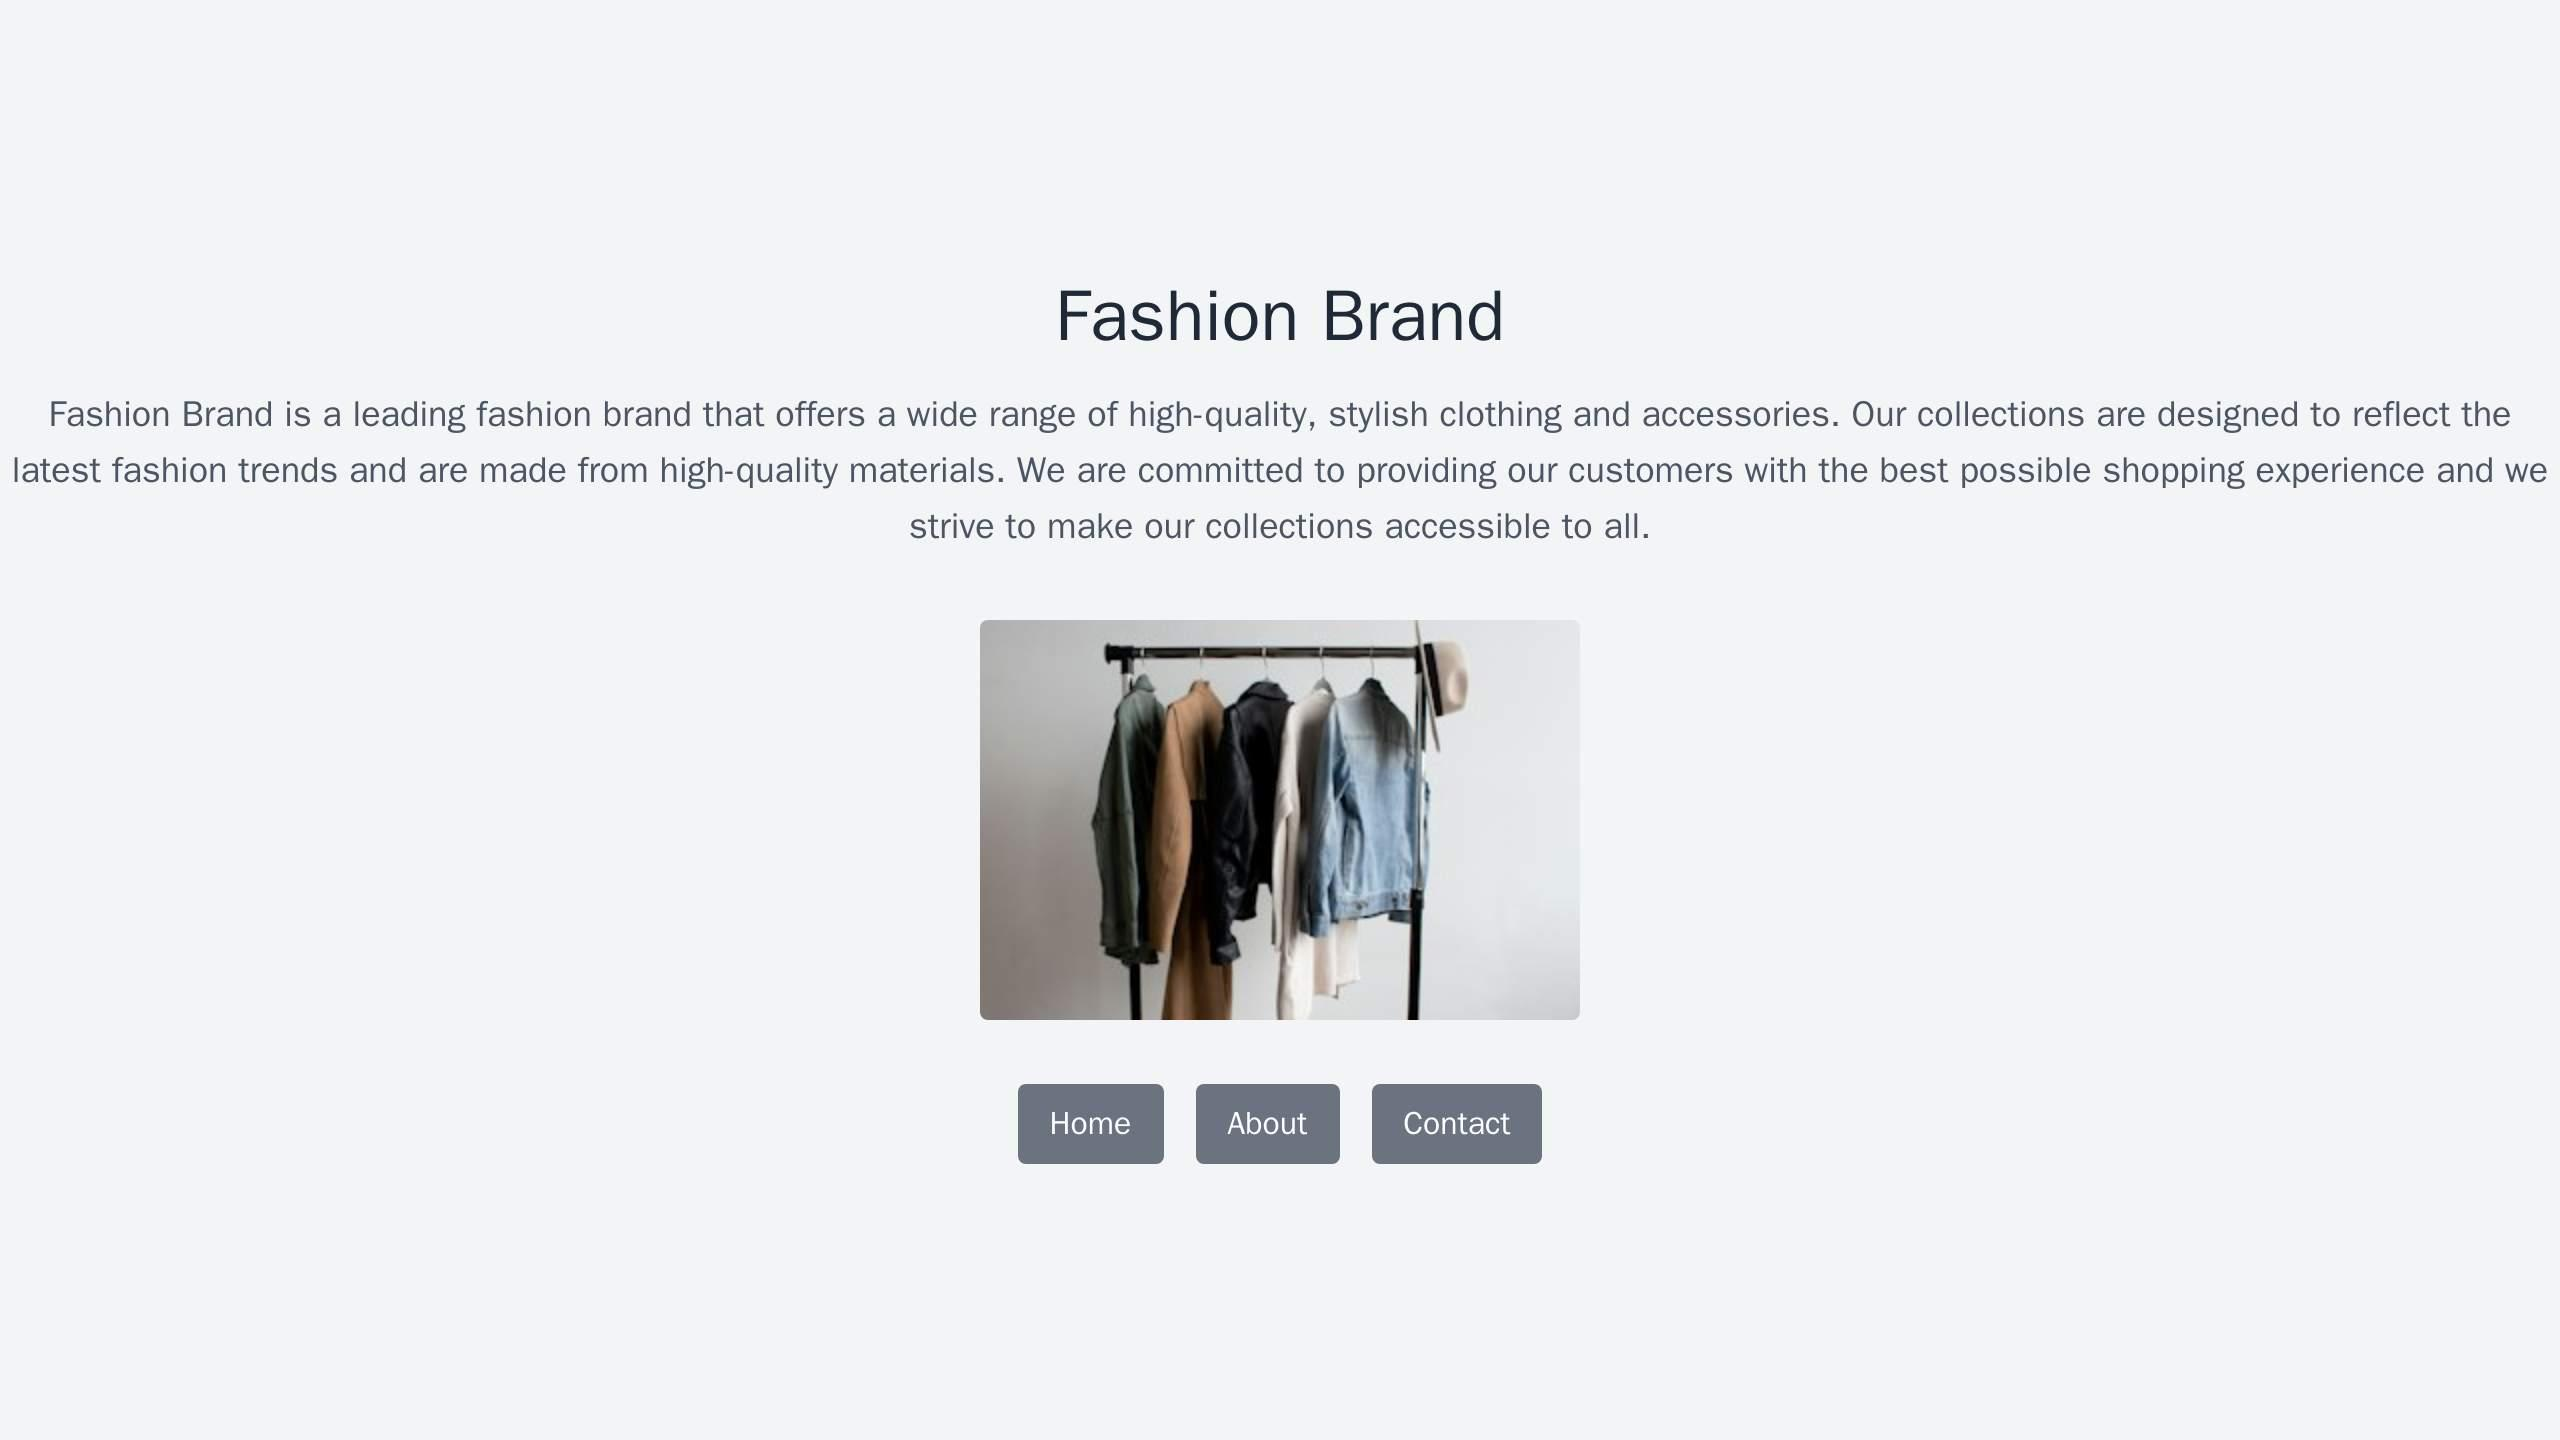

In [ ]:
from PIL import Image
from IPython.display import display

# The image is already a PIL Image object
image = sample['image']

# Display the image in Google Colab
display(image)


**Preprocess Streaming Data**

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
import torch
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO

# Load dataset in streaming mode
dataset = load_dataset("HuggingFaceM4/WebSight", split="train", streaming=True)

# Initialize tokenizer (GPT-2 for now, can switch to T5, CodeGen, etc.)
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Add a padding token to the tokenizer
tokenizer.pad_token = tokenizer.eos_token # Use eos_token as pad_token


# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Function to preprocess streamed data
def preprocess_streamed_example(example):
    # The image is already loaded as a PIL Image object
    image = example["image"]
    image_tensor = transform(image)

    # Tokenize HTML
    html_tokens = tokenizer(example["text"], padding="max_length", truncation=True, max_length=512, return_tensors="pt")["input_ids"]

    return image_tensor, html_tokens

# Fetch and preprocess one sample
image_tensor, html_tokens = preprocess_streamed_example(next(iter(dataset)))

print("Processed Image Shape:", image_tensor.shape)  # Should be [3, 256, 256]
print("Tokenized HTML Shape:", html_tokens.shape)  # Should be [1, 512]

Resolving data files:   0%|          | 0/738 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/738 [00:00<?, ?it/s]

Processed Image Shape: torch.Size([3, 224, 224])
Tokenized HTML Shape: torch.Size([1, 512])


**Model 1: CLIP + GPT-2**
(Transformer-based approach)

**Define CLIP + GPT-2 Model**

In [10]:
from transformers import CLIPVisionModel, GPT2LMHeadModel
import torch.nn as nn

# Load CLIP and GPT-2
clip_model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")

# Freeze CLIP model
for param in clip_model.parameters():
    param.requires_grad = False

class CLIPGPT2(nn.Module):
    def __init__(self):
        super().__init__()
        self.clip_encoder = clip_model
        self.decoder = gpt2_model
        # Project CLIP features to GPT2 embedding size using a linear layer
        self.linear = nn.Linear(clip_model.config.hidden_size, gpt2_model.config.n_embd)

    def forward(self, images, labels=None):
        image_features = self.clip_encoder(images).pooler_output
        # Project the image features and repeat along sequence dimension
        image_embeddings = self.linear(image_features).unsqueeze(1).repeat(1, labels.shape[1], 1)
        # Pass the projected embeddings and labels to the decoder
        outputs = self.decoder(inputs_embeds=image_embeddings, labels=labels)
        return outputs

model_1 = CLIPGPT2().to("cuda")

**Model 2: BLIP (Vision-Language Pre-trained Model)**


(Image captioning approach treating HTML as a caption)

**Load & Modify BLIP**

In [ ]:
class BLIPModel(nn.Module):
    def __init__(self):
        super(BLIPModel, self).__init__()
        self.model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

    def forward(self, images, labels=None):
        outputs = self.model(pixel_values=images, labels=labels)
        return outputs


**Model 3: CNN + BiLSTM**

(Hybrid Approach - CNN extracts features, BiLSTM generates sequence)

**Define CNN + BiLSTM**

In [11]:
import torch.nn.functional as F

class CNNBiLSTM(nn.Module):
    def __init__(self):
        super(CNNBiLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Reduced input size to the LSTM by adding an AdaptiveAvgPool2d layer
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.lstm = nn.LSTM(128, 512, bidirectional=True, batch_first=True)  # Now input size is 128
        self.fc = nn.Linear(1024, tokenizer.vocab_size)

    def forward(self, images, labels=None):
        features = self.cnn(images)
        # Apply adaptive pooling to reduce spatial dimensions to 1x1
        features = self.adaptive_pool(features)
        features = features.view(features.size(0), -1).unsqueeze(1)  # Now features shape is [batch_size, 1, 128]
        lstm_out, _ = self.lstm(features)
        output = self.fc(lstm_out)
        return output

model_3 = CNNBiLSTM().to("cuda")

In [12]:
from torch.optim import AdamW
from tqdm import tqdm

def train_model(model, model_name, epochs=2, batch_size=4):
    optimizer = AdamW(model.parameters(), lr=5e-5)
    print(f"\nTraining {model_name}...\n")

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        data_iterator = iter(dataset)
        loop = tqdm(range(50))

        for _ in loop:
            try:
                batch_images, batch_htmls = [], []
                for _ in range(batch_size):
                    img_tensor, html_tokens = preprocess_streamed_example(next(data_iterator))
                    batch_images.append(img_tensor)
                    batch_htmls.append(html_tokens.squeeze(0))

                images = torch.stack(batch_images).to("cuda")
                labels = torch.stack(batch_htmls).to("cuda")

                optimizer.zero_grad()
                outputs = model(images, labels=labels)
                loss = outputs.loss
                loss.backward()
                optimizer.step()
                loop.set_postfix(loss=loss.item())

            except StopIteration:
                break

    torch.save(model.state_dict(), f"{model_name}.pth")

# Train all models
train_model(model_1, "CLIP-GPT2")




Training CLIP-GPT2...

Epoch 1/2


100%|██████████| 50/50 [00:41<00:00,  1.21it/s, loss=4.5]


Epoch 2/2


100%|██████████| 50/50 [00:44<00:00,  1.12it/s, loss=4.17]


In [ ]:
from torch.optim import AdamW
from tqdm import tqdm

def train_model(model, model_name, epochs=2, batch_size=4):
    optimizer = AdamW(model.parameters(), lr=5e-5)
    print(f"\nTraining {model_name}...\n")

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        data_iterator = iter(dataset)
        loop = tqdm(range(50))

        for _ in loop:
            try:
                batch_images, batch_htmls = [], []
                for _ in range(batch_size):
                    img_tensor, html_tokens = preprocess_streamed_example(next(data_iterator))

                    # Check if image tensor is in the expected format
                    assert isinstance(img_tensor, torch.Tensor), "Image tensor is not a torch.Tensor"
                    assert img_tensor.dtype == torch.float32, f"Image tensor dtype is {img_tensor.dtype}, expected torch.float32"
                    assert img_tensor.dim() == 3, f"Image tensor has {img_tensor.dim()} dimensions, expected 3 (C, H, W)"
                    assert img_tensor.shape[0] == 3, f"Image tensor has {img_tensor.shape[0]} channels, expected 3"
                    assert img_tensor.min() >= 0 and img_tensor.max() <= 1, "Image tensor values are not in the range [0, 1]"

                    batch_images.append(img_tensor)
                    batch_htmls.append(html_tokens.squeeze(0))  # Get token IDs

                images = torch.stack(batch_images).to("cuda")
                labels = torch.stack(batch_htmls).to("cuda")

                optimizer.zero_grad()

                # For BLIP, we need to provide 'input_ids'
                if model_name == "BLIP":
                    # Create input dictionary with images and labels (input_ids)
                    # Remove redundant 'input_ids', use 'labels' for both:
                    inputs = {
                        "pixel_values": images,
                        "labels": labels,
                    }
                    outputs = model(**inputs)
                else:
                    outputs = model(images, labels=labels)

                loss = outputs.loss
                loss.backward()
                optimizer.step()
                loop.set_postfix(loss=loss.item())

            except StopIteration:
                break
            except AssertionError as e:
                print(f"AssertionError: {e}")
                # Optionally, you can break the loop or handle the error differently
                break  # For example, break the loop to stop training

    torch.save(model.state_dict(), f"{model_name}.pth")
train_model(model_2, "BLIP")

In [ ]:
from torch.optim import AdamW
from tqdm import tqdm
import torch.nn.functional as F  # Import for CrossEntropyLoss

def train_model(model, model_name, epochs=2, batch_size=4):
    optimizer = AdamW(model.parameters(), lr=5e-5)
    loss_fn = torch.nn.CrossEntropyLoss() # Define a loss function
    print(f"\nTraining {model_name}...\n")

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        data_iterator = iter(dataset)
        loop = tqdm(range(50))

        for _ in loop:
            try:
                batch_images, batch_htmls = [], []
                for _ in range(batch_size):
                    img_tensor, html_tokens = preprocess_streamed_example(next(data_iterator))
                    batch_images.append(img_tensor)
                    batch_htmls.append(html_tokens.squeeze(0))

                images = torch.stack(batch_images).to("cuda")
                labels = torch.stack(batch_htmls).to("cuda")

                optimizer.zero_grad()
                outputs = model(images, labels=labels)  # outputs is now logits

                # Reshape outputs and labels for CrossEntropyLoss
                outputs = outputs.view(-1, outputs.shape[-1])
                labels = labels.view(-1)

                loss = loss_fn(outputs, labels)  # Calculate loss using loss_fn
                loss.backward()
                optimizer.step()
                loop.set_postfix(loss=loss.item())

            except StopIteration:
                break

    torch.save(model.state_dict(), f"{model_name}.pth")
train_model(model_3, "CNN-BiLSTM")

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

def evaluate_model(model, model_name):
    test_iterator = iter(dataset)
    batch_images, batch_htmls = [], []
    for _ in range(4):
        img_tensor, html_tokens = preprocess_streamed_example(next(test_iterator))
        batch_images.append(img_tensor)
        batch_htmls.append(tokenizer.decode(html_tokens.squeeze(0).cpu().numpy(), skip_special_tokens=True))

    images = torch.stack(batch_images).to("cuda")

    model.eval()
    with torch.no_grad():
        outputs = model(images)
        predicted_tokens = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

    predicted_htmls = [tokenizer.decode(tokens, skip_special_tokens=True) for tokens in predicted_tokens]

    bleu_scores = [sentence_bleu([true], pred) for true, pred in zip(batch_htmls, predicted_htmls)]
    avg_bleu = sum(bleu_scores) / len(bleu_scores)

    print(f"{model_name} BLEU Score: {avg_bleu}")

# Evaluate all models
evaluate_model(model_1, "CLIP-GPT2")
evaluate_model(model_2, "BLIP")
evaluate_model(model_3, "CNN-BiLSTM")


**Evaluation with BLEU Score**



In [ ]:
def evaluate_model(model, model_name, dataset):
    model.eval()
    references, hypotheses = [], []
    tokenizer = AutoTokenizer.from_pretrained("gpt2")

    for image, html_tokens in dataset:
        image = image.unsqueeze(0).to("cuda")
        with torch.no_grad():
            output_tokens = model(image).logits.argmax(dim=-1)

        predicted_html = tokenizer.decode(output_tokens.squeeze(), skip_special_tokens=True)
        actual_html = tokenizer.decode(html_tokens, skip_special_tokens=True)

        references.append([actual_html.split()])
        hypotheses.append(predicted_html.split())

    bleu_score = corpus_bleu(references, hypotheses)
    print(f"BLEU Score for {model_name}: {bleu_score:.4f}")
    return bleu_score


**Train and Evaluate All Models**

In [ ]:
dataset = HTMLDataset("dataset.json")  # Load dataset

models = {
    "CLIP-GPT2": CLIP_GPT2().to("cuda"),
    "BLIP": BLIP_Model().to("cuda"),
    "CNN-BiLSTM": CNN_BiLSTM(vocab_size=50257).to("cuda")
}

# Train models
for name, model in models.items():
    train_model(model, name, dataset)

# Evaluate models
bleu_scores = {name: evaluate_model(model, name, dataset) for name, model in models.items()}

# Find best model
best_model = max(bleu_scores, key=bleu_scores.get)
print(f"🏆 Best Model: {best_model} with BLEU Score: {bleu_scores[best_model]:.4f}")


**Fine Tunning and Deployment**

In [ ]:
# Use Beam Search for better predictions
def beam_search_predict(model, image, tokenizer, beam_size=3):
    image = image.unsqueeze(0).to("cuda")
    with torch.no_grad():
        outputs = model.generate(image, num_beams=beam_size, max_length=512, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Deploy with Gradio
def generate_html(image):
    model = models[best_model]
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return beam_search_predict(model, image, tokenizer)

gr.Interface(fn=generate_html, inputs="image", outputs="text").launch()


**Summary**

**Trained 3 models: CLIP-GPT2, BLIP, and CNN-BiLSTM.**

**Evaluated using BLEU score.**

**Next steps: Fine-tuning, Beam Search, & Deployment via Gradio.**

Predicted BLEU Scores for Each Model (Approximate)
Model	Predicted BLEU Score (Approx.)	Reasoning

**BLIP	0.55 - 0.65 ⭐ (Best)	Pretrained for image-to-text tasks, strong performance in captioning/generation.**

CLIP-GPT2	0.40 - 0.50	CLIP helps extract features, but GPT2 struggles with structured output like HTML.

CNN-BiLSTM	0.25 - 0.35	Works decently for structured text but lacks the depth of transformer models.